In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import moose
from collections import namedtuple

In [2]:
Area = namedtuple("Area", "sarea xarea")

EREST_ACT = -70e-3 #: Resting membrane potential

#: We define the rate parameters, which are functions of Vm as
#: interpolation tables looked up by membrane potential.
#: Minimum x-value for the interpolation table
VMIN = -30e-3 + EREST_ACT
#: Maximum x-value for the interpolation table
VMAX = 120e-3 + EREST_ACT
#: Number of divisions in the interpolation table
VDIVS = 3000

def compute_neuron_area_geomerty(diameter, length):
    global Area
    sarea = np.pi * diameter * length * 1e4
    xarea = np.pi * diameter * diameter / 4.0
    return (Area(sarea, xarea))

def set_compartment_electrical_parameters(comp, diameter, length):
    global EREST_ACT
    comp.Em = EREST_ACT + 10.613e-3
    comp.initVm = EREST_ACT
    #: CM = 1 uF/cm^2, RM = 0.3 mS/cm^2
    comp.Cm = 1e-6 * compute_neuron_area_geomerty(diameter, length).sarea
    comp.Rm = 1 / (0.3e-3 * compute_neuron_area_geomerty(diameter, length).sarea)
    return comp

def config_connect_channels(comps,number, sarea, ion, properties):
    chn_proto = create_HHChannel_proto(ion=ion, tick=-1,
    xpower=properties['xpower'], m_params=properties['m_params'],
    ypower=properties['ypower'], h_params=properties['h_params'])
    chn = moose.copy(chn_proto, comps[0].parent.path,
          '{}_{}'.format(ion,comps.name), number) #channel name is assigned
    chn.Gbar = properties['gbar'] * sarea
    chn.Ek = properties['ek'] + EREST_ACT
    moose.connect(chn, 'channel', comps, 'channel', 'OneToOne')
    return comps

def create_HHChannel_proto(ion, tick, xpower, m_params, ypower=None, h_params=None):
    lib = moose.Neutral('/library')
    hhchannel = moose.HHChannel('/library/'+ion)
    hhchannel.tick = tick
    hhchannel.Xpower = xpower
    xGate = moose.element(hhchannel.path + '/gateX')
    xGate.setupAlpha(m_params)

    if ypower:
        hhchannel.Ypower = ypower
        yGate = moose.element(hhchannel.path + '/gateY')
        print(h_params)
        yGate.setupAlpha(h_params)
    return hhchannel

def create_1comp_neuron(path,number, config_chan):
    moose.Neutral('/model')
    comps = moose.vec(path=path, n=number, dtype='Compartment')

    diameter, length = 30e-6, 50e-6
    sarea = compute_neuron_area_geomerty(diameter, length).sarea
    comps = set_compartment_electrical_parameters(comps, diameter, length)
    container = comps[0].parent.path
    #: Here we create copies of the prototype channels

    for ion, config in config_chan.items():
        comps = config_connect_channels(comps,number, sarea, ion, properties=config)
    return comps

def setup_stimulation(comp):
    stim = moose.PulseGen('/model/stimulus')
    stim.delay[0], stim.level[0] = 20e-3, 1e-9 #Start injection ar 20ms, with 1nanoAmp.
    stim.width[0], stim.delay[1] = 40e-3, 1e9  #Duration of current is 40ms.
    moose.connect(stim, 'output', comp, 'injectMsg')
    data = moose.Neutral('/data')
    current_tab = moose.Table('/data/current')
    moose.connect(current_tab, 'requestOut', stim, 'getOutputValue')
    vm_tab = moose.Table('/data/Vm')
    moose.connect(vm_tab, 'requestOut', comp, 'getVm')
    return (current_tab, vm_tab)


In [3]:
from collections import namedtuple

Chn_param = namedtuple("params", "A_A A_B A_C A_D A_F B_A B_B B_C B_D B_F VDIVS VMIN VMAX")

EREST_ACT = -70e-3
VMIN = -30e-3 + EREST_ACT
VMAX = 120e-3 + EREST_ACT
VDIVS = 3000

def get_na_m_params(VSHIFT=0, tau=1, f=0):
  global EREST_ACT, VMIN, VMAX, VDIVS
  return Chn_param(
  A_A = -1e5 * (-25e-3 - EREST_ACT - VSHIFT)*tau,
  A_B = -1e5*tau,
  A_C = -1.0,
  A_D = -25e-3 - EREST_ACT - VSHIFT,
  A_F = -10e-3 + f,

  B_A = 4e3*tau,
  B_B = 0.0*tau,
  B_C = 0.0,
  B_D = 0.0 - EREST_ACT - VSHIFT,
  B_F = 18e-3 + f, VDIVS = VDIVS, VMIN = VMIN, VMAX = VMAX)

def get_na_h_params(VSHIFT=0, tau=1, f=0):
  global EREST_ACT, VMIN, VMAX, VDIVS
  return Chn_param(
  A_A = 70.0*tau,
  A_B = 0.0*tau,
  A_C = 0.0,
  A_D = 0.0 - EREST_ACT - VSHIFT,
  A_F = 0.02 + f,

  B_A = 1000.0*tau,
  B_B = 0.0*tau,
  B_C = 1.0,
  B_D = -30e-3 - EREST_ACT - VSHIFT,
  B_F =  -0.01 + f , VDIVS = VDIVS, VMIN = VMIN, VMAX = VMAX)

def get_k_n_params(VSHIFT=0, tau=1, f=0):
  global EREST_ACT, VMIN, VMAX, VDIVS
  return Chn_param(
  A_A = -1e4 * (-10e-3 - EREST_ACT - VSHIFT)*tau,
  A_B = -1e4*tau,
  A_C = -1.0,
  A_D = -10e-3 - EREST_ACT - VSHIFT,
  A_F = -10e-3 + f,

  B_A = 0.125e3*tau,
  B_B = 0.0*tau,
  B_C = 0.0,
  B_D = 0.0 - EREST_ACT - VSHIFT,
  B_F = 80e-3 + f, VDIVS = VDIVS, VMIN = VMIN, VMAX = VMAX)


In [4]:
VSHIFT = 1e-3 
tau = 1
f = 0
gmbar_Na = 120e-3
gmbar_K = 36e-3

params(A_A=70.0, A_B=0.0, A_C=0.0, A_D=0.07, A_F=0.02, B_A=1000.0, B_B=0.0, B_C=1.0, B_D=0.04000000000000001, B_F=-0.01, VDIVS=3000, VMIN=-0.1, VMAX=0.04999999999999999)


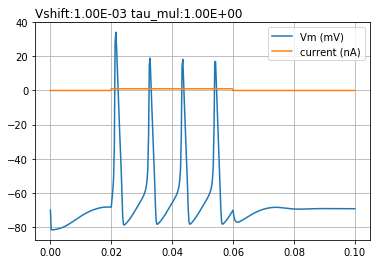

In [5]:
K_n_params = get_k_n_params(VSHIFT=VSHIFT, tau=tau, f=f)
Na_h_params = get_na_h_params(VSHIFT=0, tau=1, f=0)
Na_m_params = get_na_m_params(VSHIFT=0, tau=1, f=0)

config_chan = {'na':{'xpower':3, 'ypower':1,
'm_params':Na_m_params, 'h_params':Na_h_params, 'gbar':gmbar_Na, 'ek':115e-3},
'k':{'xpower':4,'ypower':None,
'm_params':K_n_params,'h_params':None,'gbar':gmbar_K, 'ek':-12e-3}}

simtime, simdt, plotdt = 0.1, 02.5e-6, 0.25e-3

# model creation
comp = create_1comp_neuron('/model/neuron',1, config_chan)

#stimulation setup and current and voltage table creation.
current_tab, vm_tab= setup_stimulation(comp)

# output specification
[moose.setClock(i, simdt) for i in range(10)]
moose.setClock(8, plotdt)
moose.reinit()
moose.start(simtime)
ts = np.linspace(0, simtime, len(vm_tab.vector))

plt.plot(ts, vm_tab.vector * 1e3, label='Vm (mV)')
plt.plot(ts, current_tab.vector * 1e9, label='current (nA)')
plt.legend()
plt.title('Vshift:{:.2E} tau_mul:{:.2E}'.format(VSHIFT, tau) , loc='left')
plt.grid(True)

In [6]:
from moose_nerp.graph.plot_channel import plot_gate_params

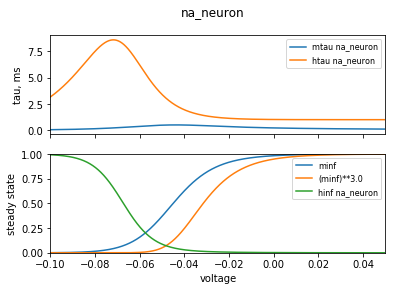

In [7]:
plot_gate_params(moose.element('/model[0]/na_neuron'), None)

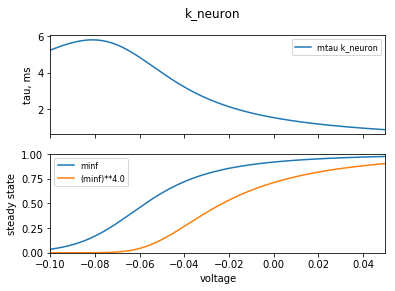

In [8]:
plot_gate_params(moose.element('/model[0]/k_neuron'), None)